# World Model Policy Evaluation

This notebook demonstrates how to rollout OpenVLA in the Bridge (WidowX) environment from within our world model, and how to grade it using a VLM.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from PIL import Image
import requests
import mediapy as media
from tqdm import tqdm
import torch
import einops
import base64
import math
import re
import cv2
from openai import OpenAI
import random
from pathlib import Path
import json

## Action scaling

In [5]:
def rescale_bridge_action(a):
    """
    Rescale Bridge (WidowX) action to the ranges expected by the world model.
    We need to call this function on the unnormalized action values returned by the policy.
    """
    wv_lo = -0.05
    wv_hi = +0.05
    wv_post_scale_max = +1.75
    wv_post_scale_min = -1.75
    rd_lo = -0.25
    rd_hi = +0.25
    rd_post_scale_max = +1.4
    rd_post_scale_min = -1.4
    # rescale end effector
    a[:3] = (a[:3] - wv_lo) / (wv_hi - wv_lo) * (
        wv_post_scale_max - wv_post_scale_min
    ) + wv_post_scale_min
    # rescale joint rotations
    a[3:6] = (a[3:6] - rd_lo) / (rd_hi - rd_lo) * (
        rd_post_scale_max - rd_post_scale_min
    ) + rd_post_scale_min
    # threshold the gripper
    a[6] = torch.where(a[6] > 0.8, -1.0, +1.0)
    return a


## VLM evaluation utils

Set your OpenAI key:
```
export OPENAI_API_KEY=<your key here>
```

In [6]:
def encode_video(video, stride=20):
    frames, idx = [], 0
    for idx, frame in enumerate(video):
        if idx % stride == 0:
            if (frame == 0).all():
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            _, buf = cv2.imencode(".jpg", frame)
            frames.append(base64.b64encode(buf).decode())
    return frames


def predict(video, task, n=5):
    frames = encode_video(video)
    prompt = f"""
Here is a sequence of frames from a robot policy which has been rolled out in a video-generation-based world model. I need your help determining whether the policy is successful. How successfully does the robot complete the following task?
Task: {task["instruction"]}
Subtasks: {task["subtasks"]}

For each subtask, give the model a score of 0 (fail) or 1 (success). Explain your reasoning. Finally, output "Total Score: <score>", where <score> is the sum of the scores on the subtasks above.

Note: Since this video was generated by a video prediction model (conditioned on robot actions), it may contain some artifacts due to the video model capacity.
Note: For the final score output, make sure to follow the "Total Score: <score>" format exactly so the score can be parsed out using a regex.
""".strip()
    client = OpenAI()
    messages = [
        {
            "role": "user",
            "content": [prompt, *[{"image": f, "resize": 256} for f in frames]],
        }
    ]
    print(prompt)
    res = client.chat.completions.create(model="gpt-4o", messages=messages, n=n)
    total_score = 0
    n_scores = 0
    for c in res.choices:
        print(c.message.content)
        m = re.search(r"Total Score: (\d+)", c.message.content.replace("**", ""))
        if m:
            total_score += (
                int(m.group(1)) / 2.0
            )  # divide by 2 since there are 2 subtasks
            n_scores += 1
    avg_score = total_score / n_scores
    print(f"Average Score: {avg_score}")
    return avg_score

## Policy Evaluation Loop

In [7]:
def evaluate_policy(vla, tasks, rollout_length=40):
    """
    Rollout an OpenVLA model on a list of tasks, and return the score on each task.
    Arguments:
        vla: An OpenVLA model from `transformers`
        tasks: A list of N tasks in loaded from a json. See "put_carrot_on_plate.json" for an example of the format.
    Returns:
        scores: A list of N scores from the VLM corresponding to each input task.
    """
    scores = []
    for task_i in tqdm(tasks, desc="completing tasks"):
        start_frame = np.array(
            Image.open(requests.get(task_i["im_0_path"], stream=True).raw).resize(
                (256, 256)
            )
        )
        media.show_image(start_frame)
        wm.reset(torch.from_numpy(start_frame).cuda().float() / 255.0)

        frames = [start_frame]
        for step in tqdm(range(rollout_length)):
            curr_frame = Image.fromarray(frames[-1])
            prompt = f"In: What action should the robot take to {task_i['instruction']}?\nOut:"
            inputs = processor(prompt, curr_frame).to(
                device="cuda", dtype=torch.bfloat16
            )
            actions = vla.predict_action(
                **inputs, unnorm_key="bridge_orig", do_sample=False
            )

            a = torch.tensor(actions)[0].cuda()
            # NOTE: OpenVLA outputs 7-dim actions, while the world model was trained with up to 10-dim actions.
            a = torch.cat([a, a.new_zeros(3)], dim=-1)  # pad with zeros
            a = rescale_bridge_action(a)

            for i, x in wm.generate_chunk(a):
                new_frame = x[0, 0].cpu().numpy()
                new_frame = np.clip(new_frame * 255, 0, 255).astype(np.uint8)
                frames.append(new_frame)
        rollout_video = np.stack(frames)
        media.show_video(rollout_video, fps=20)
        avg_score = predict(rollout_video, task=task_i)
        scores.append(avg_score)
    return np.array(scores)

## Init world model

In [8]:
# Download the BridgeV2 checkpoint if needed
ckpt_path = Path("bridge_v2_ckpt.pt")
if not ckpt_path.exists():
    import gdown
    with ckpt_path.open("wb") as f:
        gdown.download("https://drive.google.com/file/d/1otjQTpxdiUXiKFmMDwlpy46zPOkFxEfA/view?usp=sharing", f, fuzzy=True)

In [9]:
from world_model import WorldModel

wm = WorldModel(ckpt_path)

/juice4/scr4/quevedo/world-model-eval/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-29 07:26:39.343941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 07:26:39.399041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 07:26:41.876949: I tensor

## Init OpenVLA

In [10]:
from transformers import AutoModelForVision2Seq, AutoProcessor

# Load Processor & VLA
processor = AutoProcessor.from_pretrained("openvla/openvla-7b", trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    "openvla/openvla-7b",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
).cuda()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Expected `transformers==4.40.1` and `tokenizers==0.19.1` but got `transformers==4.53.0` and `tokenizers==0.21.4`; there might be inference-time regressions due to dependency changes. If in doubt, pleaseuse the above versions.
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:00<00:00,  8.52it/s]


## Scrape jpgs from the Bridge website

In [11]:
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin

def find_jpgs_http(url, session=None):
    if session is None:
        session = requests.Session()
    resp = session.get(url)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, 'html.parser')
    for link in soup.find_all('a'):
        href = link.get('href')
        if not href or href.startswith('?') or href.startswith('/'):
            continue

        full_url = urljoin(url, href)
        if href.endswith('/'):
            yield from find_jpgs_http(full_url, session=session)
        elif href.lower().endswith('im_0.jpg'):
            yield full_url

To choose a different task, edit the `base_url`, `instruction`, and `subtasks` below.

In [12]:
import random
tasks = []
base_url = "https://rail.eecs.berkeley.edu/datasets/bridge_release/raw/bridge_data_v1/berkeley/toysink2_bww/put_carrot_on_plate/"
for jpg_url in find_jpgs_http(base_url):
    tasks.append(
        {
            "im_0_path": jpg_url,
            "instruction": "put carrot on plate",
            "subtasks": ["Pick up the carrot.", "Place the carrot on the plate."],
        }
    )
tasks = random.sample(tasks, 20)

completing tasks:   0%|                                   | 0/1 [00:00<?, ?it/s]

""

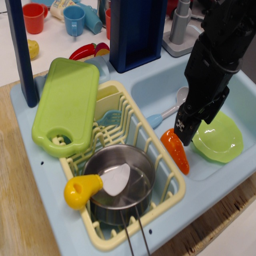


100%|███████████████████████████████████████████| 40/40 [00:30<00:00,  1.31it/s]


Here is a sequence of frames from a robot policy which has been rolled out in a video-generation-based world model. I need your help determining whether the policy is successful. How successfully does the robot complete the following task?
Task: put carrot on plate
Subtasks: ['Pick up the carrot.', 'Place the carrot on the plate.']

For each subtask, give the model a score of 0 (fail) or 1 (success). Explain your reasoning. Finally, output "Total Score: <score>", where <score> is the sum of the scores on the subtasks above.

Note: Since this video was generated by a video prediction model (conditioned on robot actions), it may contain some artifacts due to the video model capacity.
Note: For the final score output, make sure to follow the "Total Score: <score>" format exactly so the score can be parsed out using a regex.


completing tasks: 100%|███████████████████████████| 1/1 [00:38<00:00, 38.32s/it]

To evaluate the robot's task performance based on the frames:

1. **Subtask: Pick up the carrot.**
   - **Frame Analysis:** In the first frame, the carrot is visible beside the robot arm. In the subsequent frames, the carrot appears to have shifted slightly, but it does not seem to be lifted or securely grasped by the robot.
   - **Score:** 0 (fail)

2. **Subtask: Place the carrot on the plate.**
   - **Frame Analysis:** The carrot does not appear to be on the plate in any of the frames.
   - **Score:** 0 (fail)

**Total Score: 0**
To evaluate the success of the robot policy, we need to assess the two subtasks:

1. **Pick up the carrot.**
   - **Score: 0 (fail)**
   - **Reasoning:** In the frames provided, the carrot appears to remain in its initial position and is not clearly being picked up by the robot.

2. **Place the carrot on the plate.**
   - **Score: 0 (fail)**
   - **Reasoning:** The carrot does not appear to be placed on the plate in any of the frames.

**Total Score: 0**
To 

In [13]:
tasks = tasks[:1]  # Just evaluate one task for demo purposes
scores = evaluate_policy(vla, tasks)
print(f"Example task: {tasks[0]}")
print(f"Mean score: {np.mean(scores)=}")
print(f"STE: {np.std(scores) / len(scores)**0.5=}")